In [131]:
import random
import tensorflow as tf
from tensorflow.keras import layers, utils, models
import os
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

In [132]:
DATA_DIR = "./sig_images"

In [133]:
def load_data(DATA_DIR=DATA_DIR, test_size=0.3, load_grayscale=True):
    """
        Loads the data into a dataframe.
        
        Arguments:
            DATA_DIR: str
            test_size: float
        Returns:
            (x_train, y_train,x_test, y_test, x_val, y_val, df)
    """
    all_imgs = []
    imgs_forged = []
    imgs_real = []
    features_dict = {}
    labels = [] # forged: 0 and real:
    mode = "rgb"
    if load_grayscale:
        mode = "grayscale"
    
    for folder in os.listdir(DATA_DIR):
        # forged images
        for sub in os.listdir(DATA_DIR+"/forge"):
            if ".Jpeg" not in sub:
                continue
            f = DATA_DIR+"/forge/" + sub
            img = utils.load_img(f, color_mode=mode, target_size=(150,150))
            all_imgs.append(utils.img_to_array(img))
            features_dict[sub] = (img, 0)
            imgs_forged.append(img)
            labels.append(0) # forged

        # real images
        for sub in os.listdir(DATA_DIR+"/real"):
            if ".Jpeg" not in sub:
                continue
            f = DATA_DIR+"/real/" + sub
            print("sub: {}".format(sub))
            img = utils.load_img(f, color_mode=mode, target_size=(150,150))
            all_imgs.append(utils.img_to_array(img))
            features_dict[sub] = (img, 1)
            imgs_real.append(img)
            labels.append(1) # real
            
    features = np.array(all_imgs)
    labels = np.array(labels)
    
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=test_size, random_state=228)
    
    print ("Generated data.")

    return X_train, X_test, y_train, y_test, features, labels



In [134]:
X_train, X_test, y_train, y_test, features, labels = load_data(load_grayscale=False)


sub: 22T10.Jpeg
sub: 26T2.Jpeg
sub: 32T10.Jpeg
sub: 35T6.Jpeg
sub: 12T19.Jpeg
sub: 10T24.Jpeg
sub: 13T7.Jpeg
sub: 13T34.Jpeg
sub: 22T5.Jpeg
sub: 18T13.Jpeg
sub: 31T1.Jpeg
sub: 38T2.Jpeg
sub: 14T30.Jpeg
sub: 39T37.Jpeg
sub: 27T29.Jpeg
sub: 37T29.Jpeg
sub: 35T14.Jpeg
sub: 29T37.Jpeg
sub: 17T20.Jpeg
sub: 36T12.Jpeg
sub: 34T2.Jpeg
sub: 26T12.Jpeg
sub: 14T26.Jpeg
sub: 27T6.Jpeg
sub: 29T21.Jpeg
sub: 39T21.Jpeg
sub: 12T3.Jpeg
sub: 17T36.Jpeg
sub: 19T28.Jpeg
sub: 39T6.Jpeg
sub: 30T5.Jpeg
sub: 10T32.Jpeg
sub: 23T1.Jpeg
sub: 31T16.Jpeg
sub: 16T4.Jpeg
sub: 13T22.Jpeg
sub: 18T29.Jpeg
sub: 11T6.Jpeg
sub: 18T5.Jpeg
sub: 16T37.Jpeg
sub: 38T20.Jpeg
sub: 28T20.Jpeg
sub: 15T27.Jpeg
sub: 37T7.Jpeg
sub: 27T13.Jpeg
sub: 24T3.Jpeg
sub: 37T13.Jpeg
sub: 15T1.Jpeg
sub: 12T23.Jpeg
sub: 20T17.Jpeg
sub: 30T17.Jpeg
sub: 11T33.Jpeg
sub: 20T4.Jpeg
sub: 29T7.Jpeg
sub: 12T35.Jpeg
sub: 19T1.Jpeg
sub: 10T2.Jpeg
sub: 13T18.Jpeg
sub: 11T25.Jpeg
sub: 33T11.Jpeg
sub: 36T3.Jpeg
sub: 23T11.Jpeg
sub: 16T21.Jpeg
sub: 28T36.Jpeg

In [135]:
#divided by 255: Because the values in the dataset range from 0 to 255.
X_train = X_train/255.0
X_test = X_test/255.0

In [136]:
def label_to_text(label=0):
    return "Forged" if label == 0 else "Real"

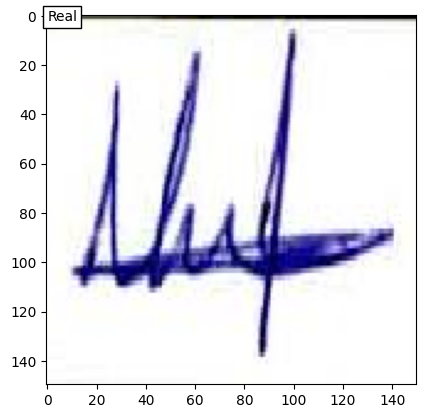

In [137]:
idx = random.randint(0, len(X_train))

plt.imshow(X_train[idx, :])
plt.text(0, 2, label_to_text(labels[idx]), bbox={'facecolor': 'white', 'pad': 3})
plt.show()

In [138]:
def mse(y_true, y_pred):
    return np.square(np.subtract(y_true,y_pred)).mean()

A_array = utils.img_to_array(A[0])
B_array = utils.img_to_array(B[0])

print ("MSE Error: {}".format(mse(A_array, B_array)))

MSE Error: 5210.08642578125


## Use Sequential model:
A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.

### **Convolution Neutral Network** ref link:
* https://www.youtube.com/@CodingLane
* https://towardsdatascience.com/build-your-first-image-classifier-with-convolution-neural-network-cnn-b4e9034ec5cb

* Tune CNN: https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-ii-hyper-parameter-42efca01e5d7

In [139]:
model = models.Sequential()
# how many layer should I use
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150,150,3)))
model.add(layers.MaxPooling2D(pool_size=3))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [140]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 49, 49, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 47, 47, 32)        9248      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 16928)             0         
                                                                 
 dense_17 (Dense)            (None, 64)               

In [141]:
history = model.fit(X_train, y_train, epochs= 5, batch_size=100)

Epoch 1/5


2023-04-14 19:31:13.930012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


46/46 [==============================] - 2s 33ms/step - loss: 0.7561 - accuracy: 0.5280
Epoch 2/5
46/46 [==============================] - 1s 27ms/step - loss: 0.6501 - accuracy: 0.6192
Epoch 3/5
46/46 [==============================] - 1s 27ms/step - loss: 0.5648 - accuracy: 0.7042
Epoch 4/5
46/46 [==============================] - 1s 26ms/step - loss: 0.5323 - accuracy: 0.7383
Epoch 5/5
46/46 [==============================] - 1s 27ms/step - loss: 0.4743 - accuracy: 0.7682


In [142]:
print(history.history)

{'loss': [0.7560884356498718, 0.6500783562660217, 0.5647962689399719, 0.5323447585105896, 0.47427013516426086], 'accuracy': [0.5280053019523621, 0.6192163228988647, 0.7042285203933716, 0.7383219003677368, 0.7682090401649475]}


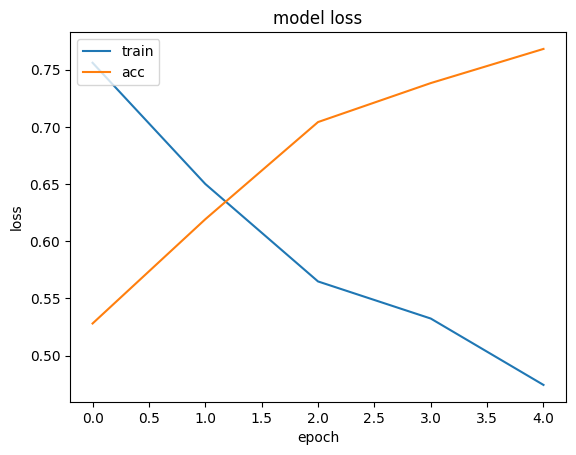

In [143]:
def plot_history(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['accuracy'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'acc'], loc='upper left')
    plt.show()

plot_history(history)

In [144]:
model.evaluate(X_test, y_test)

 7/61 [==>...........................] - ETA: 0s - loss: 0.4594 - accuracy: 0.7946

2023-04-14 19:31:21.316112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/61 [==============================] - 1s 9ms/step - loss: 0.4607 - accuracy: 0.7805


[0.46068495512008667, 0.7804752588272095]

## Make Prediction for all images

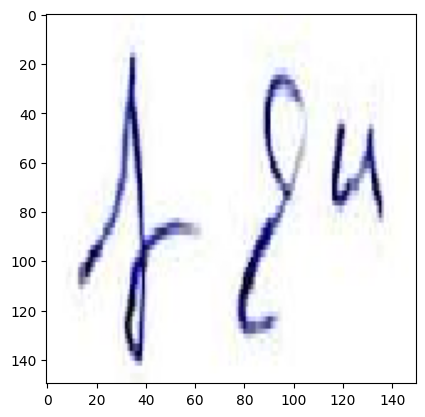

1/1 [==============================] - 0s 49ms/step
prediction: Real, actual: is Real


2023-04-14 19:31:22.102664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [145]:
idx2 = random.randint(0, len(features))
plt.imshow(features[idx2, :] / 255.)
plt.show()

y_pred = model.predict(features[idx2, :].reshape(1, 150, 150, 3))
y_pred = 1 if y_pred > 0.5 else 0

print("prediction: {}, actual: is {}".format(label_to_text(y_pred), label_to_text(labels[idx2])))